In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")
import math

In [62]:
## This file provides starter code for extracting features from the xml files and
## for doing some learning.
##
## The basic set-up: 
## ----------------
## main() will run code to extract features, learn, and make predictions.
## 
## extract_feats() is called by main(), and it will iterate through the 
## train/test directories and parse each xml file into an xml.etree.ElementTree, 
## which is a standard python object used to represent an xml file in memory.
## (More information about xml.etree.ElementTree objects can be found here:
## http://docs.python.org/2/library/xml.etree.elementtree.html
## and here: http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/)
## It will then use a series of "feature-functions" that you will write/modify
## in order to extract dictionaries of features from each ElementTree object.
## Finally, it will produce an N x D sparse design matrix containing the union
## of the features contained in the dictionaries produced by your "feature-functions."
## This matrix can then be plugged into your learning algorithm.
##
## The learning and prediction parts of main() are largely left to you, though
## it does contain code that randomly picks class-specific weights and predicts
## the class with the weights that give the highest score. If your prediction
## algorithm involves class-specific weights, you should, of course, learn 
## these class-specific weights in a more intelligent way.
##
## Feature-functions:
## --------------------
## "feature-functions" are functions that take an ElementTree object representing
## an xml file (which contains, among other things, the sequence of system calls a
## piece of potential malware has made), and returns a dictionary mapping feature names to 
## their respective numeric values. 
## For instance, a simple feature-function might map a system call history to the
## dictionary {'first_call-load_image': 1}. This is a boolean feature indicating
## whether the first system call made by the executable was 'load_image'. 
## Real-valued or count-based features can of course also be defined in this way. 
## Because this feature-function will be run over ElementTree objects for each 
## software execution history instance, we will have the (different)
## feature values of this feature for each history, and these values will make up 
## one of the columns in our final design matrix.
## Of course, multiple features can be defined within a single dictionary, and in
## the end all the dictionaries returned by feature functions (for a particular
## training example) will be unioned, so we can collect all the feature values 
## associated with that particular instance.
##
## Two example feature-functions, first_last_system_call_feats() and 
## system_call_count_feats(), are defined below.
## The first of these functions indicates what the first and last system-calls 
## made by an executable are, and the second records the total number of system
## calls made by an executable.
##
## What you need to do:
## --------------------
## 1. Write new feature-functions (or modify the example feature-functions) to
## extract useful features for this prediction task.
## 2. Implement an algorithm to learn from the design matrix produced, and to
## make predictions on unseen data. Naive code for these two steps is provided
## below, and marked by TODOs.
##
## Computational Caveat
## --------------------
## Because the biggest of any of the xml files is only around 35MB, the code below 
## will parse an entire xml file and store it in memory, compute features, and
## then get rid of it before parsing the next one. Storing the biggest of the files 
## in memory should require at most 200MB or so, which should be no problem for
## reasonably modern laptops. If this is too much, however, you can lower the
## memory requirement by using ElementTree.iterparse(), which does parsing in
## a streaming way. See http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/
## for an example. 

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util


def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)
        
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
        
    cols = []
    rows = []
    data = []        
    for i in xrange(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].iteritems():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   

    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict
    

## Here are two example feature-functions. They each take an xml.etree.ElementTree object, 
# (i.e., the result of parsing an xml file) and returns a dictionary mapping 
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made. 
      (in other words, it returns a dictionary indicating what the first and 
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen
            
    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

## The following function does the feature extraction, learning, and prediction
def main():
    train_dir = "train"
    test_dir = "test"
    outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument
    
    # TODO put the names of the feature functions you've defined above in this list
    ffs = [first_last_system_call_feats, system_call_count_feats]
    
    # extract features
    print "extracting training features..."
    X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
    print "done extracting training features"
    print
    
    # TODO train here, and learn your classification parameters
    print "learning..."
    learned_W = np.random.random((len(global_feat_dict),len(util.malware_classes)))
    print "done learning"
    print
    
    # get rid of training data and load test data
    del X_train
    del t_train
    del train_ids
    print "extracting test features..."
    X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
    print "done extracting test features"
    print
    
    # TODO make predictions on text data and write them out
    print "making predictions..."
    preds = np.argmax(X_test.dot(learned_W),axis=1)
    print "done making predictions"
    print
    
    print "writing predictions..."
    util.write_predictions(preds, test_ids, outputfile)
    print "done!"
    

In [63]:
train_dir = "train"
test_dir = "test"
outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument

# TODO put the names of the feature functions you've defined above in this list
ffs = [first_last_system_call_feats, system_call_count_feats]

# extract features
print "extracting training features..."
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
print "done extracting training features"

extracting training features...
done extracting training features


In [8]:
X_train.shape

(3086, 31)

### Feature Engineering TODO Roger to add your input

### Approaches
#### Random Forest

In [100]:
RF = RandomForestClassifier()
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy")

Random Forest Classifier
[ 0.78685897  0.77419355  0.79058442  0.78211382  0.78559738]


#### Multinomial Bayes

In [99]:
from sklearn.naive_bayes import MultinomialNB
MNNB = MultinomialNB()
print "Multinomial NB"
print cross_val_score(MNNB, X_train, t_train, cv=5, scoring="accuracy")

Multinomial NB
[ 0.60737179  0.64193548  0.63311688  0.63739837  0.6710311 ]


In [47]:
MNNB.fit(X_train, t_train)
predictions = MNNB.predict(X_train)

In [48]:
def get_prediction_accuracy(predictions, t_train):
    in_both = [i for i, j in zip(predictions, t_train) if i == j]
    print len(in_both) / float(len(predictions))

#### SVM

In [101]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, t_train)
print "SVM Classifier"
print cross_val_score(lin_clf, X_train, t_train, cv=5, scoring="accuracy")

SVM Classifier
[ 0.52884615  0.18064516  0.27272727  0.55121951  0.04255319]


### Data Exploration

In [86]:
df['class'].describe()

count    3086.000000
mean        8.378483
std         2.795222
min         0.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        14.000000
Name: class, dtype: float64

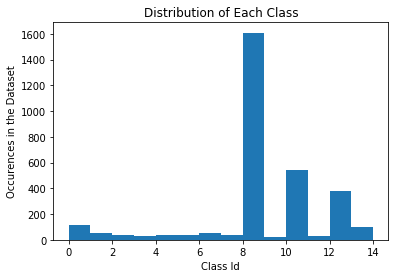

In [89]:
%matplotlib inline
plt.hist(df['class'], bins=14)
plt.title("Distribution of Each Class")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

### 2 layer TODO BRIAN

In [97]:
df = pd.DataFrame(X_train.toarray())
df['class'] = t_train
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,class
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,643,8
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5422,6
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,93,12
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,430,8
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1085,10


In [77]:
len(none)

114

In [ ]:
### 

#### Outputting predictions

In [92]:
print "extracting test features..."
X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
print "done extracting test features"

extracting test features...
done extracting test features


In [93]:
RF_preds = RF.predict(X_test)
print "writing predictions..."
util.write_predictions(RF_preds, test_ids, "rfpredictions.csv")

writing predictions...


In [94]:
MNNB_preds = MNNB.predict(X_test)
print "writing predictions..."
util.write_predictions(MNNB_preds, test_ids, "mnnbpredictions.csv")

writing predictions...


In [96]:
lin_clf_preds = lin_clf.predict(X_test)
print "writing predictions..."
util.write_predictions(lin_clf_preds, test_ids, "svmpredictions.csv")

writing predictions...
